The objective of this competition is to predict 3 months of item-level sales data at different store locations.

**File descriptions**

train.csv - Training data
test.csv - Test data (Note: the Public/Private split is time based)
sample_submission.csv - a sample submission file in the correct format

**Data fields**

date - Date of the sale data. There are no holiday effects or store closures.
store - Store ID
item - Item ID
sales - Number of items sold at a particular store on a particular date.

Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors.

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.figsize'] = [12, 8]
%matplotlib inline



In [4]:
print(sns.__version__)

0.9.0


In [5]:
train = pd.read_csv("../data/train.csv.zip")
test = pd.read_csv("../data/test.csv.zip")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
id       45000 non-null int64
date     45000 non-null object
store    45000 non-null int64
item     45000 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.4+ MB


OBSERVATIONS:

1.  It is fairly small dataset with only about 900K training instances and 45K test instances. 
2. There are only 3 initial features, date, store, and item. 

In [10]:
# Convert the date field
train.loc[:,'date'] = pd.to_datetime(train.date)
test.loc[:,'date'] = pd.to_datetime(test.date)

In [11]:
# the time range of the training data
print("The time range of the training data")
print(train.date.min(), train.date.max(), (train.date.max()-train.date.min()).days+1)
print("The time range of the test data")
print(test.date.min(), test.date.max(), (test.date.max()-test.date.min()).days+1)

The time range of the training data
2013-01-01 00:00:00 2017-12-31 00:00:00 1826
The time range of the test data
2018-01-01 00:00:00 2018-03-31 00:00:00 90


In [12]:
# number of unique stores
print("Number of unique stores in train data = {0:d}".format(train.store.nunique()))
print("Number of unique stores in test data  = {0:d}".format(test.store.nunique()))

Number of unique stores in train data = 10
Number of unique stores in test data  = 10


In [13]:
train.store.value_counts().sort_index()

1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: store, dtype: int64

In [14]:
test.store.value_counts().sort_index()

1     4500
2     4500
3     4500
4     4500
5     4500
6     4500
7     4500
8     4500
9     4500
10    4500
Name: store, dtype: int64

In [15]:
# number of unique items
print("Number of unique items in train data = {0:d}".format(train.item.nunique()))
print("Number of unique items in test data  = {0:d}".format(test.item.nunique()))

Number of unique items in train data = 50
Number of unique items in test data  = 50


In [16]:
train.item.value_counts().sort_index()

1     18260
2     18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
24    18260
25    18260
26    18260
27    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
38    18260
39    18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
50    18260
Name: item, dtype: int64

In [17]:
test.item.value_counts().sort_index()

1     900
2     900
3     900
4     900
5     900
6     900
7     900
8     900
9     900
10    900
11    900
12    900
13    900
14    900
15    900
16    900
17    900
18    900
19    900
20    900
21    900
22    900
23    900
24    900
25    900
26    900
27    900
28    900
29    900
30    900
31    900
32    900
33    900
34    900
35    900
36    900
37    900
38    900
39    900
40    900
41    900
42    900
43    900
44    900
45    900
46    900
47    900
48    900
49    900
50    900
Name: item, dtype: int64

**OBSERVATIONS**

1.  The stores present in the training data are present in the test data. 
2.  The same items are present in both data. 
3. The number of observations per store and per item is the same. 

## EDA

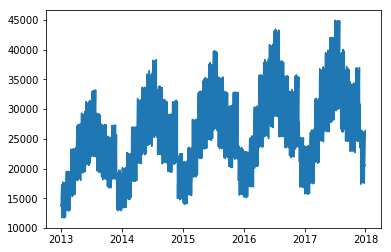

In [18]:
# Plot the daily total sales
# The trend clearly shows seasonality and the total annual sales increases steadily
daily_sales = train.groupby('date')['sales'].sum()
plt.plot(daily_sales)

In [19]:
# find the cycle length, yearly cycle, July is the highest
daily_sales.loc[daily_sales.groupby(daily_sales.index.year).idxmax()]

date
2013-07-28    33216
2014-07-27    38318
2015-07-12    39794
2016-07-10    43427
2017-07-02    44936
Name: sales, dtype: int64

In [20]:
# Compute annual growth for each store and item combination
train2 = train.set_index('date')
train2.index = train2.index + pd.DateOffset(years=1)
train2 = train2.reset_index()
train2.head()

,date,store,item,sales
0,2014-01-01,1,1,13
1,2014-01-02,1,1,11
2,2014-01-03,1,1,14
3,2014-01-04,1,1,13
4,2014-01-05,1,1,10


In [21]:
train_yearly_diff = pd.merge(train, train2, on=['date','store','item'], how='left', suffixes=('_1','_2')).dropna()

In [22]:
train_yearly_diff.loc[:,'yearly_growth'] = (train_yearly_diff.sales_1 - train_yearly_diff.sales_2) / (train_yearly_diff.sales_2)
train_yearly_diff = train_yearly_diff.replace([np.inf, -np.inf], np.nan).dropna()

(array([2.75000e+02, 2.43230e+04, 1.51158e+05, 2.80907e+05, 1.90000e+05,
        5.96410e+04, 1.58930e+04, 4.87200e+03, 1.79600e+03, 6.58000e+02,
        4.80000e+02, 1.88000e+02, 1.14000e+02, 6.80000e+01, 3.80000e+01,
        2.30000e+01, 1.90000e+01, 6.00000e+00, 1.50000e+01, 1.00000e+00,
        1.20000e+01, 2.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ,
         2.3,  2.6,  2.9,  3.2,  3.5,  3.8,  4.1,  4.4,  4.7,  5. ,  5.3,
         5.6,  5.9,  6.2,  6.5,  6.8,  7.1,  7.4,  7.7,  8. ,  8.3,  8.6,
         8.9,  9.2,  9.5,  9.8, 10.1, 10.4, 10

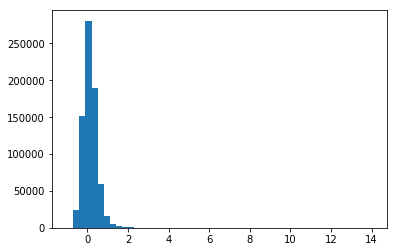

In [23]:
plt.hist(train_yearly_diff.yearly_growth, bins=50)

In [24]:
# For each item at a store, the sales does not always increase from year to year
train_yearly_diff.yearly_growth.describe()

count    730499.000000
mean          0.127495
std           0.338269
min          -1.000000
25%          -0.090909
50%           0.105263
75%           0.306122
max          14.000000
Name: yearly_growth, dtype: float64

In [26]:
# Sales change per store
train_sales_by_store = train.groupby(['date','store'])['sales'].sum().reset_index()
train_sales_by_store.head()

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032


In [27]:
train_sales_by_store2 = train_sales_by_store.set_index('date')
train_sales_by_store2.index = train_sales_by_store2.index + pd.DateOffset(years=1)
train_sales_by_store2 = train_sales_by_store2.reset_index()

train_sales_by_store_growth = pd.merge(train_sales_by_store, train_sales_by_store2, on=['date','store'], how='left', suffixes=('_1','_2')).dropna()
train_sales_by_store_growth.loc[:,'yearly_growth'] = (train_sales_by_store_growth.sales_1 - train_sales_by_store_growth.sales_2) / (train_sales_by_store_growth.sales_2)
train_sales_by_store_growth = train_sales_by_store_growth.replace([np.inf, -np.inf], np.nan).dropna()

(array([6.000e+00, 2.700e+01, 1.210e+02, 3.070e+02, 3.180e+02, 2.320e+02,
        1.940e+02, 3.060e+02, 2.820e+02, 2.210e+02, 1.120e+02, 1.370e+02,
        1.760e+02, 1.100e+02, 4.100e+01, 9.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 2.400e+01, 5.000e+01, 1.310e+02, 2.280e+02,
        3.460e+02, 4.680e+02, 7.080e+02, 9.100e+02, 1.034e+03, 9.370e+02,
        7.690e+02, 6.600e+02, 7.490e+02, 8.940e+02, 1.012e+03, 9.000e+02,
        6.760e+02, 4.900e+02, 3.340e+02, 1.830e+02, 1.320e+02, 1.090e+02,
        9.400e+01, 5.900e+01, 4.900e+01, 3.100e+01, 1.600e+01, 9.000e+00,
        4.000e+00, 1.000e+00]),
 array([-0.3760407 , -0.35885546, -0.34167022, -0.32448497, -0.30729973,
        -0.29011449, -0.27292924, -0.255744  , -0.23855875, -0.22137351,
        -0.20418827, -0.18700302, -0.16981778, -0.15263254, -0.13544729,
        -0.11826205, -0.10107681, -0.08389156, -0.06670632, -0.04952107,
        -0.03233583, -0.01515059,  0.00203466,  0.0192199 ,  0.03640514,
         0.

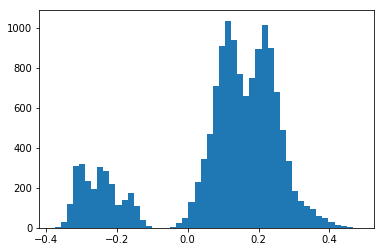

In [28]:
plt.hist(train_sales_by_store_growth.yearly_growth, bins=50)

In [29]:
train_sales_by_store_growth.yearly_growth.describe()

count    14610.000000
mean         0.095179
std          0.177327
min         -0.376041
25%          0.064863
50%          0.136955
75%          0.215951
max          0.483221
Name: yearly_growth, dtype: float64

In [33]:
# Find the stores with at least one day of decreasing yearly change
train_sales_by_store_growth.loc[train_sales_by_store_growth.yearly_growth < 0, 'store'].value_counts().sort_index()

1     265
2     266
3     266
4     267
5     275
6     267
7     272
8     263
9     266
10    263
Name: store, dtype: int64

In [42]:
# Weekend sales higher, pd.Timestamp('2013-01-06').weekday() = 6, Monday=0, Sunday=6
df = train_sales_by_store_growth.loc[train_sales_by_store_growth.yearly_growth < 0, 'date'].value_counts().sort_index()
(df.loc[df == 10].index + pd.DateOffset(years=-1)).weekday.value_counts()

6    208
5     52
dtype: int64

In [43]:
type((df.loc[df == 10].index + pd.DateOffset(years=-1)).weekday)

pandas.core.indexes.numeric.Int64Index

(array([1.100e+01, 4.100e+01, 9.300e+01, 2.680e+02, 6.560e+02, 1.266e+03,
        1.680e+03, 1.735e+03, 1.691e+03, 1.523e+03, 1.312e+03, 1.031e+03,
        7.990e+02, 5.890e+02, 4.270e+02, 5.070e+02, 7.890e+02, 1.237e+03,
        2.118e+03, 3.053e+03, 4.126e+03, 5.086e+03, 5.576e+03, 5.742e+03,
        5.733e+03, 5.349e+03, 4.798e+03, 4.046e+03, 3.254e+03, 2.522e+03,
        1.860e+03, 1.290e+03, 9.380e+02, 6.460e+02, 4.160e+02, 2.800e+02,
        2.000e+02, 1.300e+02, 8.000e+01, 6.100e+01, 2.900e+01, 1.700e+01,
        1.100e+01, 8.000e+00, 1.200e+01, 4.000e+00, 4.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00]),
 array([-4.74916388e-01, -4.48563221e-01, -4.22210055e-01, -3.95856889e-01,
        -3.69503722e-01, -3.43150556e-01, -3.16797389e-01, -2.90444223e-01,
        -2.64091056e-01, -2.37737890e-01, -2.11384723e-01, -1.85031557e-01,
        -1.58678390e-01, -1.32325224e-01, -1.05972057e-01, -7.96188909e-02,
        -5.32657245e-02, -2.69125580e-02, -5.59391520e-04,  2.57937749e-

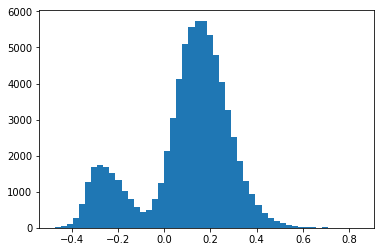

In [31]:
# Sales change per item
train_sales_by_item = train.groupby(['date','item'])['sales'].sum().reset_index()

train_sales_by_item2 = train_sales_by_item.set_index('date')
train_sales_by_item2.index = train_sales_by_item2.index + pd.DateOffset(years=1)
train_sales_by_item2 = train_sales_by_item2.reset_index()

train_sales_by_item_growth = pd.merge(train_sales_by_item, train_sales_by_item2, on=['date','item'], how='left', suffixes=('_1','_2')).dropna()
train_sales_by_item_growth.loc[:,'yearly_growth'] = (train_sales_by_item_growth.sales_1 - train_sales_by_item_growth.sales_2) / (train_sales_by_item_growth.sales_2)
train_sales_by_item_growth = train_sales_by_item_growth.replace([np.inf, -np.inf], np.nan).dropna()

plt.hist(train_sales_by_item_growth.yearly_growth, bins=50)

In [ ]:
# potential features: 